# Anexo 1: Código Simulación de agentes

A continuación se presenta el codigo realizado para simular un modelo basado en agentes en el que se incorpora crédito, deuda y propension al ahorro. Además, se incorpora la definición de movilidad social y se calcula el ínidice de Gini para medir la desigualdad

In [1]:
#Importar librerias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

Definición de funciones para la inicialización

In [2]:
# funcion 1 de inicializacion en la que a todos se les asigna inicialmente lo mismo 
def initialize_agents(ag,size,prom):
    for i in range(size):
        ag[i]=prom

In [3]:
#funcion 2 de inicializacion en la que a los primeros se les asigna 0 y a los demas el dinero promedio
def initialize2(ag,size,prom,ndif):
    for s in range(ndif):
        ag[s]=0.0
    for l in range(ndif,size,1):
        ag[l]=np.divide((size*prom),(size-ndif))

In [4]:
#funcion 3 de inicializacion en la que a cada agente se le da un ingreso aleatorio
def initialize3(ag): 
    random.seed(1)
    for i in range(len(ag)):
        eps=random.uniform(0,100)
        ag[i]=eps
    M_total=np.sum(ag)
    T=np.divide(M_total,len(ag))
    return M_total,T

Definición función de interacción para los agentes incluyendo, credito, deuda y propensión al ahorro

In [5]:
def interaction(ag,N,nsteps,Lambda,cr,mdeuda):
    #epsilon=random.uniform(-1,1) #primer cambio epsilon entre -1 y 1
    for k in range(nsteps):
        epsilon=random.uniform(-1,1)
        i=random.randint(0,N-1)
        j=random.randint(0,N-1) 
        if i!=j:
            '''
            print('i',i)
            print('j',j)
            print('vector credito antes de interactuar', cr)
            '''
            tempi=ag[i]
            tempj=ag[j]
            delta_m=(1-Lambda)*(epsilon*tempj-(1-epsilon)*tempi)
            '''
            print('tempi',tempi)
            print('tempj', tempj)
            print('deltam',delta_m)
            '''
            mi = tempi + delta_m #winner
            mj = tempj - delta_m #loser
            '''
            print('mi despues de interactuar', mi)
            print('mj despues de interactuar', mj)
            '''
            crfi = cr[i]-np.abs(mi)#vi' (si i perdiera y se hiciera la transaccción)      
            crfj = cr[j]-np.abs(mj)# vj' (si j perdiera y se hiciera la transaccción)
            #condicion para j  -> deuda cuando pido dinero prestado
            
            if ((crfj>mdeuda and mj>mdeuda) and (mj<0 and mi>=np.abs(mj))): #segundo cambio agrupar los ands
                 #tercer cambio poner if en otra posicion
                cr[j] += mj        #vector v para guardar la deuda 
                   #condicion para i  -> credito cuando presto dinero
                cr[i] += -1*mj #para garantizar que i tenga dinero suficiente para hacer el prestamo
                ag[i]=mi-np.abs(mj)
                ag[j]=0
                '''    
                print('credito j',cr[j])
                print('credito i', cr[i])
                print('mi despues credito', mi)
                print('mj despues credito', mj)
                '''
          
            #si j es el que presta
            if ((crfi>mdeuda and mi>mdeuda) and (mi<0 and mj>=np.abs(mi))): #segundo cambio agrupar los ands
            #tercer cambio poner if en otra posicion
                cr[i] += mi        #vector v para guardar la deuda 
            #condicion para i  -> credito cuando presto dinero
                cr[j] += -1*mi #para garantizar que i tenga dinero suficiente para hacer el prestamo
                ag[j]=mj-np.abs(mi)
                ag[i]=0
                '''
                print('credito i',cr[i])
                print('credito j', cr[j])
                print('mi despues credito', mi)
                print('mj despues credito', mj)
                '''    
           
            #guardar los ingresos en u
            if (mi>=0 and mj>=0):
                ag[i]=mi
                ag[j]=mj
            '''
            print('ingreso i', ag[i])
            print('ingreso j', ag[j])
            print('fin del paso de tiempo')
            print('         ')
            '''
            #u viene de los ingresos u=[0,infinto] y v=[-mdeuda,infinito]


Función creación de intervalos para asignar las clases sociales 

In [6]:
def crear_intervalos(w,mini,maxi):
    Imin=mini
    Imax=maxi
    ancho=np.divide((Imax-Imin),1.0*w)
    intervalos=[]
    for k in range(w):
        mink=Imin+k*ancho
        maxk=Imin+(k+1)*ancho
        intervalos.append(mink)
    intervalos.append(Imax)
    return intervalos

Función para asignar la clase según el rango de ingreso

In [7]:
def asignar_clase(ag,intervalos,l_clase,w):
    for i in range(len(ag)):
        for k in range(w):
            if (k != w-1):
                if (ag[i]>=intervalos[k] and ag[i]<intervalos[k+1]):
                    l_clase[i]=k
            if k==w-1:
                if (ag[i]>=intervalos[k] and ag[i]<=intervalos[k+1]):
                    l_clase[i]=k


Función para calcular los valores minimo y máximo de los intervalos a crear

In [8]:
def evaluar_minmax(ag_i,ag_f):
    valor_min=0
    valor_max=0
    min_agi=np.min(ag_i)
    min_agf=np.min(ag_f)
    max_agi=np.max(ag_i)
    max_agf=np.max(ag_f)
    valor_min=min(min_agi,min_agf)
    valor_max=max(max_agi,max_agf)
    return valor_min, valor_max

Función para inicializar el vector de agentes final 

In [9]:
def iniciar_agf(ag_i,ag_f):
    for i in range(len(ag_i)):
        ag_f[i]=ag_i[i]

In [10]:
#función para calcular la entropía
def entropia(ag,w):
    #parametros para los intervalos
    S=ag.size # numero de agentes
    Imin=np.min(ag)
    Imax=np.max(ag)
    ancho=np.divide((Imax-Imin),1.0*w)
    intervalos=[]
    #parametros calculo de la entropia de Shannon
    pi=np.zeros(w)
    pilnpi=np.zeros(w)
    frec=np.zeros(w)
    #crear los intervalos
    for k in range(w):
        mink=Imin+k*ancho
        maxk=Imin+(k+1)*ancho
        intervalos.append(mink)
        #empezamos a calcular las frecuencias
        if k==w-1: #para el ultimo intervalo la condicion debe ser cerrada para maxk
            frec[k]=len(ag[(ag>=mink) & (ag<=maxk)])
        else:
            frec[k]=len(ag[(ag>=mink) & (ag<maxk)])
        #una vez que ya tenemos la frecuencia, calculamos pi
        pi[k]=np.divide(frec[k],1.0*S)
        #calculamos pi*lnpi
        if pi[k]==0:
            pilnpi[k]=0
        else:
            pilnpi[k]=pi[k]*np.log(pi[k])
    #agregamos el ultimo limite a los intervalos
    intervalos.append(Imax)
    #calculamos la suma de pilnpi
    sumpilnpi=np.sum(pilnpi)
    entropy=-1*sumpilnpi
    #al final retornamos los intervalos, las frecuencias y la entropia
    return intervalos,frec,entropy


Función para calcular el índice de Gini

In [11]:
#funcion para calcular el gini
def gini(df0):
    N=df0.size
    Itotal=np.sum(df0)
    #creamos arrays para calcular poblacion e ingreso acumulado
    Xing=np.zeros(N) #ingreso de cada individuo/ingreso total
    Xcum=np.zeros(N) #ingreso acumulado
    Xsum=np.zeros(N) #Xk+Xk-1
    Ypob=np.zeros(N) #1/pobtotal
    Ycum=np.zeros(N) #poblacion agregada
    Ydiff=np.zeros(N) #Yk-Yk-1
    XsumYdiff=np.zeros(N) #(Xk+Xk-1)(Yk-Yk-1)
    
    for i in range(N):
        #llenamos array Xing
        Xing[i]=1.0*df0[i]/Itotal
        #llenamos array Xcum
        if i==0:
            Xcum[i]=Xing[i]
        else:
            Xcum[i]=Xing[i]+Xcum[i-1]
        #llenamos array Xsum
        if i==0:
            Xsum[i]=Xcum[i]
        else:
            Xsum[i]=Xcum[i]+Xcum[i-1]
        #hacemos lo mismo para Y
        Ypob[i]=1.0/N
        if i==0:
            Ycum[i]=Ypob[i]
        else:
            Ycum[i]=Ypob[i]+Ycum[i-1]
        if i==0:
            Ydiff[i]=Ycum[i]
        else:
            Ydiff[i]=Ycum[i]-Ycum[i-1]
        #llenar array de multiplicacion (Xk+Xk+1)(Yk-Yk-1)
        XsumYdiff[i]=Xsum[i]*Ydiff[i]
    #una vez todo este lleno calculamos la suma
    sumaXsumYdiff=np.sum(XsumYdiff)
    Gini=1.0-sumaXsumYdiff
    return Gini

In [12]:
#funcion para calcular el Theil
def theil(df0):
    N=df0.size
    Itotal=np.sum(df0)
    Ui=np.zeros(N) #array fraccion de ingreso con respecto al total
    UilnUi=np.zeros(N)
    for j in range(N):
        Ui[j]=1.0*df0[j]/Itotal
        if Ui[j]==0:
            UilnUi[j]=0
        else:
            UilnUi[j]=Ui[j]*np.log(Ui[j])
    #calculamos la suma Ui*lnUi
    sumaUilnUi=np.sum(UilnUi)
    Theil=1+sumaUilnUi
    Theil_norm=1+np.divide(sumaUilnUi,np.log(N))
    return Theil_norm

Función para calcular el número de individuos que incrementaron su ingreso

In [13]:
def prob_incrementoingreso(final, inicial, numAgentes):
    diferencia = final-inicial
    #print('diferencia', diferencia)
    num = len(diferencia[diferencia>0])
    print('# de agentes que aumentaron su ingreso', num)
    probabilidad = num/numAgentes
    print('probabilidad de aumentar ingreso', probabilidad)
    return probabilidad

Función para calcular la probabilidad de ascender una o más clases sociales (movilidad social)

In [14]:
def prob_ascenderclase(ag_i,ag_f,w,c_inicial,c_final):
    N=len(ag_i) #numero de agentes
    minI,maxI=evaluar_minmax(ag_i,ag_f) #crear valores minimo y maximo para intervalos
    intervalos_com=crear_intervalos(w,minI,maxI) #creacion intervalos
    asignar_clase(ag_i,intervalos_com,c_inicial,w) #asignacion de clase arreglo agentes inicial
    asignar_clase(ag_f,intervalos_com,c_final,w) #asignacion de clase arreglo agentes final
    diferencia=c_final-c_inicial # calcular la diferencia de clase
    num_subieron=np.count_nonzero(diferencia>=1) #calcular el numero de personas que ascendieron una clase o mas
    prob=num_subieron/N
    return intervalos_com,prob    

In [15]:
def sumar_uv(ag_f,cr,suma_t):
    for l in range(len(ag_f)):
        suma_t[l]=ag_f[l]+cr[l] 

# Comienzo de la simulación

Definición de constantes y arreglos iniciales

In [86]:
#Definicion de constantes
N=1000 #numero de agentes
W=10 #numero de estados
nsteps=1*10**4 # numero de pasos de tiempo
Lambda=0.6
max_deuda=-1*20
agentes_inicial=np.zeros(N) #creamos un array en cada casilla tenemos el dinero del agente i-esimo al inicio
agentes_final=np.zeros(N) #arreglo con ingreso final de cada uno de los agentes
credito=np.zeros(N)   #arreglo v para guardar el credito y la deuda
clases_inicial=np.zeros(N) #arreglo para asignar la clase en la que esta cada agente al inicio
clases_final=np.zeros(N)  #arreglo para asignar la clase de cada agente al final
intervalos_comun=np.zeros(W+1) #intervalos para construir el histograma y asignar las clases
diferencia=np.zeros(N)  #arreglo para encontrar cuantos individuos aumentan una clase o mas
suma_total=np.zeros(N)

In [87]:
#empezar simulacion

M,T=initialize3(agentes_inicial)
iniciar_agf(agentes_inicial,agentes_final)
interaction(agentes_final,N,nsteps,Lambda,credito,max_deuda)
sumar_uv(agentes_final,credito,suma_total)
intervalos,movilidad=prob_ascenderclase(agentes_inicial,agentes_final,W,clases_inicial,clases_final)
   

In [88]:
#dinero total y dinero promedio
print('dinerototal:',M)
print('dinero promedio por agente:', T)

dinerototal: 51413.70278623857
dinero promedio por agente: 51.413702786238574


# Gráficas 

Histograma Ingreso Final

Text(0.5, 1.0, 'Distribución de ingreso para los individuos')

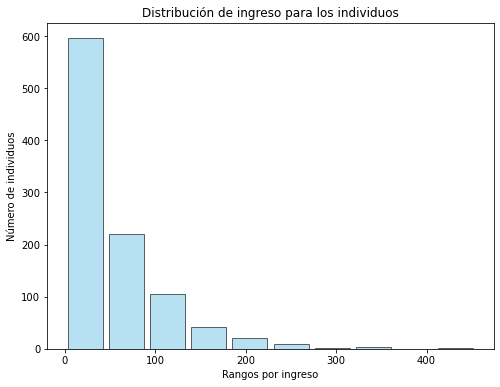

In [68]:
#Histograma Ingreso final
fig = plt.figure(figsize=(8,6))
plt.hist(x=agentes_final,bins=intervalos,color="skyblue",rwidth=0.85,lw=1,edgecolor='black',alpha=0.6)
plt.xlabel('Rangos por ingreso')
plt.ylabel('Número de individuos')
plt.title('Distribución de ingreso para los individuos')
#plt.xticks(intervals)
#fig.savefig('CC01.png')

In [69]:
#obtener intervalos para la distribución de la suma total u+v
min_suma=np.min(suma_total)
max_suma=np.max(suma_total)
intervalos_suma=crear_intervalos(W,min_suma,max_suma)

Histograma para la suma total u+v

Text(0.5, 1.0, 'Distribución de dinero total m para los individuos')

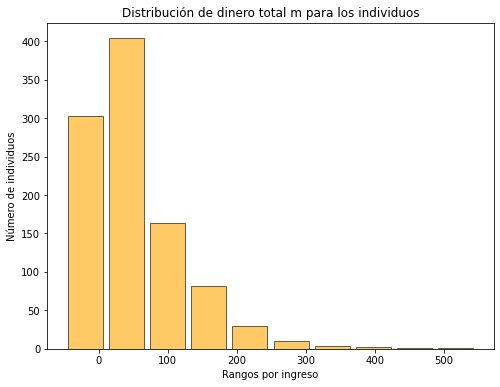

In [70]:
fig = plt.figure(figsize=(8,6))
plt.hist(x=suma_total,bins=intervalos_suma,color="orange",rwidth=0.85,lw=1,edgecolor='black',alpha=0.6)
plt.xlabel('Rangos por ingreso')
plt.ylabel('Número de individuos')
plt.title('Distribución de dinero total m para los individuos')
#plt.xticks(intervals)
#fig.savefig('CC01.png')

Cálculo del indice de Gini

In [89]:
ing_sort=np.sort(agentes_final)
l1gini = gini(ing_sort)

print('El índice de Gini: ')
print(l1gini)

El índice de Gini: 
0.5071000890207571


Movilidad Social

In [90]:
#Movilidad calculada
print('Movilidad: ', movilidad)

Movilidad:  0.288


# Exportación de datos

Enviar datos ingreso u

In [91]:
ing=pd.DataFrame(data=agentes_final)
ing.to_excel('ingresom-20.xlsx')

Enviar datos dinero total (ingreso+credito)

In [92]:
creing=pd.DataFrame(data=suma_total)
creing.to_excel('sumatm-20.xlsx')